In [1]:
import matplotlib.pyplot as plt 

# Set the font family to Arial
# https://g.co/gemini/share/3898a74b2d77
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial'] # Add Arial to the sans-serif list

In [2]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-labs/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

## Non-exonic non-enhancer Chen windows, with Gnocchi, and various features (e.g. GC content)

In [3]:
import polars as pl

def get_unconstrained_noncoding_chen_windows(): 
    df = pl.read_csv(
        # non-exonic windows
        f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.features.constraint_scores.bed', 
        separator='\t',
    )
    df = df.filter(pl.col('window overlaps enhancer') == False) # putatively unconstrained windows 
    df = df.to_pandas()
    df['gnocchi_rank'] = df['gnocchi'].rank(method='average')/len(df)
    return df 
    
UNCONSTRAINED_NONCODING_CHEN_WINDOWS = get_unconstrained_noncoding_chen_windows()
UNCONSTRAINED_NONCODING_CHEN_WINDOWS

,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi,depletion_rank_constraint_score,depletion_rank_constraint_score_complement,gnocchi_rank
0,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657,0.679834,0.320166,0.687422
1,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925,0.320987,0.679013,0.721978
2,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243,0.718503,0.281497,0.514622
3,chr1,1467000,1468000,2.958469,273,False,False,0.651,0.039046,0.025852,...,0.636364,0.552345,0.583014,0.574087,NaN,False,326.453703,0.805056,0.194944,0.972236
4,chr1,1476000,1477000,-0.662737,301,False,False,0.651,0.039046,0.025852,...,0.556444,0.595440,0.582994,0.573887,NaN,False,289.719448,0.883274,0.116726,0.384657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693265,chr9,137136000,137137000,3.277688,258,False,False,0.555,0.150095,0.005393,...,0.631369,0.551045,0.588594,0.583316,NaN,False,316.292417,0.558267,0.441733,0.981886
693266,chr9,137137000,137138000,2.779895,254,False,False,0.555,14.102295,1.698819,...,0.586414,0.559444,0.587014,0.583278,NaN,False,302.336307,0.422128,0.577872,0.964800
693267,chr9,137138000,137139000,3.286597,219,False,False,0.556,0.150095,0.005393,...,0.616384,0.584242,0.588514,0.583253,217.0,True,273.337005,0.002164,0.997836,0.982109
693268,chr9,137146000,137147000,6.685589,237,False,False,0.556,0.004152,0.000249,...,0.666334,0.620738,0.600204,0.582346,116.0,True,364.670293,0.545990,0.454010,0.999896


## Central Limit Theorem (CLT) predicts that z-scores should be standard-normal distributed

The number of distinct ALT alleles $N_i \in \{0, 1, 2, 3\} $ at a site $i$ is a categorical variable with site-dependent mean $\langle N_i \rangle$ and variance $\text{var} (N_i)$. (See [model](https://github.com/quinlan-lab/constraint-tools/blob/main/define-model/germline-model.ipynb).) Since these random variables are independent, but not identically distributed, the [Lyapunov CLT](https://en.wikipedia.org/wiki/Central_limit_theorem#Lyapunov_CLT) applies. This theorm states that, if the number of sites $l$ in a window is large enough (we consider $l=1000$), then $N = \sum_i N_i$ is distributed as: 

\begin{equation}
\frac{N - \langle N \rangle}{\sqrt{\text{var}(N)}} \sim \text{Normal}(0, 1) 
\end{equation}

where 

$$ 
\langle N \rangle = \sum_i \langle N_i \rangle 
$$ 

and 

$$ 
\text{var}(N) = \sum_i \text{var}(N_i).
$$


If one simulates many windows (e.g., with different sequence contexts), and then generates a single SNV count for each window so generated, then the distribution of z-scores of those windows will be a standard normal. 




## Gnocchi distribution is over-dispersed 

sum of standard normal distribution: 58285.99999999943
actual number of intervals: 58286


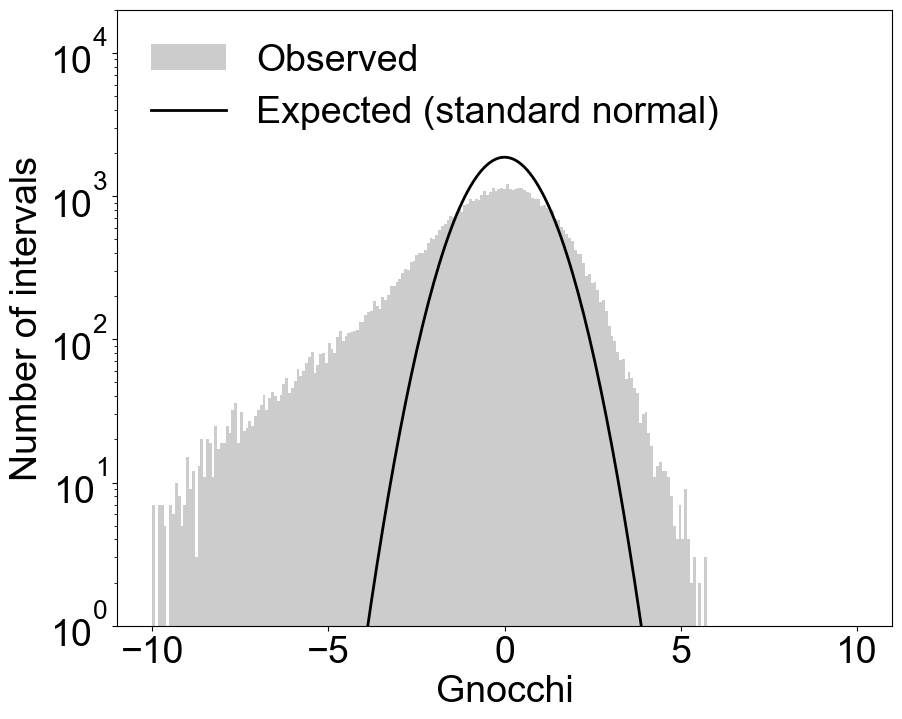

In [30]:
import numpy as np 

plt.rcParams.update({'font.size': 27})

def plot_gnocchi_distribution_vs_standard_normal(df, feature, std_scale=0.1):
    mean_feature_value = df[feature].mean()
    std_feature_value = df[feature].std()
    df = df[
        (df[feature] > mean_feature_value - std_scale*std_feature_value) & 
        (df[feature] < mean_feature_value + std_scale*std_feature_value)
    ]

    bins = np.linspace(-10, 10, 250)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    bin_width = bins[1] - bins[0]

    plt.figure(figsize=(10, 8))
    plt.hist(
        df['gnocchi'],
        bins=bins, # type: ignore
        # histtype='stepfilled',
        alpha=0.2,
        color='black',
        label='Observed',
    )

    # plot standard normal 
    x = bin_centers
    y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
    number_examples = len(df)
    y_scaled = y * number_examples * bin_width  
    plt.plot(x, y_scaled, color='black', lw=2, label='Expected (standard normal)')

    print('sum of standard normal distribution:', y_scaled.sum())
    print('actual number of intervals:', number_examples)

    plt.xlabel('Gnocchi')
    plt.ylabel('Number of intervals')
    plt.yscale('log')
    plt.ylim(1, 2e4)
    plt.legend(frameon=False, loc='upper left')

plot_gnocchi_distribution_vs_standard_normal(
    df=UNCONSTRAINED_NONCODING_CHEN_WINDOWS,
    feature='GC_content_1000bp',
) 